In [3]:
#Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import ultralytics
from ultralytics import YOLO 
from roboflow import Roboflow
from IPython.display import Image 
import yaml
from pprint import pprint
import cv2
import os 
import warnings 
warnings.filterwarnings("ignore")
ultralytics.checks()

Ultralytics 8.3.251  Python-3.11.5 torch-2.6.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
Setup complete  (8 CPUs, 15.7 GB RAM, 703.5/952.3 GB disk)


## Plotting a image from train, with corresponding label

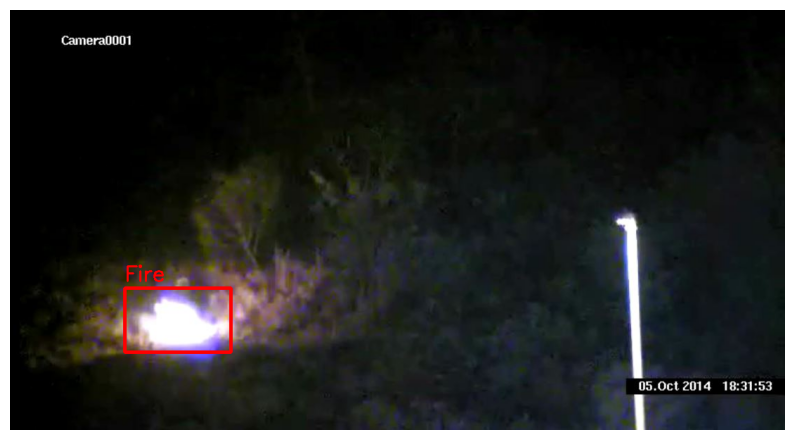

In [12]:
import cv2
import matplotlib.pyplot as plt

# 1. Load image and get dimensions
image = cv2.imread('../data/processed/train/images/AoF00001.jpg')
h, w, _ = image.shape

# 2. Read the label file
with open('../data/processed/train/labels/AoF00001.txt', 'r') as f:
    line = f.readline().split()
    # Convert string values to floats
    cls, x_c, y_c, wb, hb = map(float, line)

# 3. Calculate pixel coordinates for the rectangle
# YOLO format (center_x, center_y, width, height) -> (x1, y1, x2, y2)
x1 = int((x_c - wb / 2) * w)
y1 = int((y_c - hb / 2) * h)
x2 = int((x_c + wb / 2) * w)
y2 = int((y_c + hb / 2) * h)

# 4. Draw rectangle and Label
cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3) # Red box
cv2.putText(image, "Fire", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# 5. Display
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Determining splits for train, val & test

In [19]:
BASE_PATH = "..\\data\\processed"

splits = ["train", "test"]

def check_split(split):
    img_dir = os.path.join(BASE_PATH, split, "images")
    lbl_dir = os.path.join(BASE_PATH, split, "labels")

    images = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    labels = [f for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    img_names = set(os.path.splitext(f)[0] for f in images)
    lbl_names = set(os.path.splitext(f)[0] for f in labels)

    missing_labels = img_names - lbl_names
    missing_images = lbl_names - img_names

    print(f"\n {split}")
    print(f"Images : {len(images)}")
    print(f"Labels : {len(labels)}")

    if not missing_labels and not missing_images:
        print("All images and labels are matched")
    else:
        print(f"Missing labels for {len(missing_labels)} images")
        print(f"Missing images for {len(missing_images)} labels")

for split in splits:
    check_split(split)


 train
Images : 17221
Labels : 17221
All images and labels are matched

 test
Images : 4306
Labels : 4306
All images and labels are matched


## Analyzing distribution of splits

We currently have no val set, have to fix to avoid shortcut learning later on. fine for now.

In [20]:
#To check balance Data 
from collections import defaultdict

def read_yolo_annotations_with_metadata(dataset_metadata):
    train_path = dataset_metadata['train'].replace('images', 'labels')
    #val_path   = dataset_metadata['val'].replace('images', 'labels')
    test_path  = dataset_metadata['test'].replace('images', 'labels')

    split_stats = {
        'train': defaultdict(int),
        #'val': defaultdict(int),
        'test': defaultdict(int)
    }

    def process_labels(label_dir, split_name):
        if not os.path.exists(label_dir):
            raise FileNotFoundError(f"Labels folder not found: {label_dir}")

        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(label_dir, label_file)

            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            # Image without objects
            if not lines:
                split_stats[split_name]['background'] += 1
                continue

            present_classes = set()
            for line in lines:
                class_id = int(line.split()[0])
                present_classes.add(class_id)

            if 0 in present_classes and 1 in present_classes:
                split_stats[split_name]['both'] += 1
            elif 1 in present_classes:
                split_stats[split_name]['fire_only'] += 1
            elif 0 in present_classes:
                split_stats[split_name]['smoke_only'] += 1
            else:
                split_stats[split_name]['background'] += 1

    process_labels(train_path, 'train')
    #process_labels(val_path, 'val')
    process_labels(test_path, 'test')

    return split_stats

In [23]:
dataset_metadata = {'names': ['smoke', 'fire'],
 'nc': 2,
 'path': '../data/processed',
 'test': '../data/processed/test/images',
 'test_count': 4306,
 'train': '../data/processed/train/images',
 'train_count': 17221}

stats = read_yolo_annotations_with_metadata(dataset_metadata)

print("Fire / Smoke Distribution Report\n")

for split in ['train','test']:
    s = stats[split]
    total = sum(s.values())

    print(f"{split.upper()} SET ({total} images)")
    print(f"- Fire only     : {s['fire_only']} ({s['fire_only']/total:.1%})")
    print(f"- Smoke only    : {s['smoke_only']} ({s['smoke_only']/total:.1%})")
    print(f"- Both present  : {s['both']} ({s['both']/total:.1%})")
    print(f"- Background    : {s['background']} ({s['background']/total:.1%})")
    print()

Fire / Smoke Distribution Report

TRAIN SET (17221 images)
- Fire only     : 944 (5.5%)
- Smoke only    : 4681 (27.2%)
- Both present  : 3763 (21.9%)
- Background    : 7833 (45.5%)

TEST SET (4306 images)
- Fire only     : 220 (5.1%)
- Smoke only    : 1186 (27.5%)
- Both present  : 895 (20.8%)
- Background    : 2005 (46.6%)



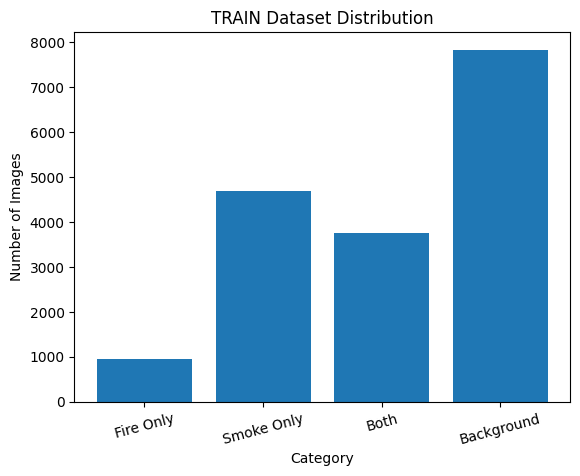

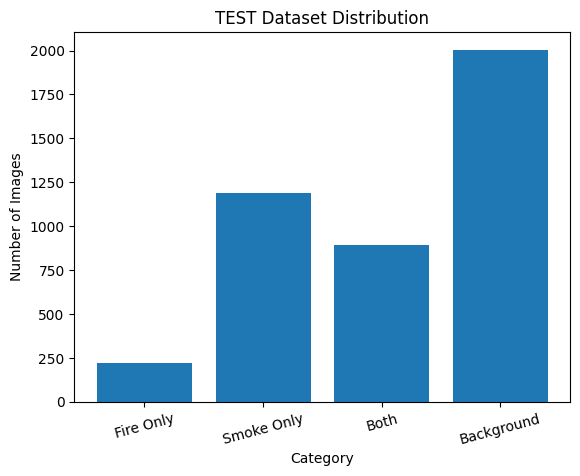

In [24]:
labels = ['Fire Only', 'Smoke Only', 'Both', 'Background']

for split in ['train', 'test']:
    values = [
        stats[split]['fire_only'],
        stats[split]['smoke_only'],
        stats[split]['both'],
        stats[split]['background']
    ]

    plt.figure()
    plt.bar(labels, values)
    plt.title(f"{split.upper()} Dataset Distribution")
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=15)
    plt.show()

In [ ]:
import os
import shutil
import random

# Use absolute paths from notebook location
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # go up from notebooks/

src_img = os.path.join(project_root, 'data', 'processed', 'train', 'images')
src_lbl = os.path.join(project_root, 'data', 'processed', 'train', 'labels')
dst_img = os.path.join(project_root, 'data', 'samples', 'images')
dst_lbl = os.path.join(project_root, 'data', 'samples', 'labels')

print(f"Source img dir: {src_img}")
print(f"Source lbl dir: {src_lbl}")
print(f"Dest img dir: {dst_img}")
print(f"Dest lbl dir: {dst_lbl}")
print()

# Check if source directories exist
if not os.path.exists(src_img):
    print(f"ERROR: Source image dir not found: {src_img}")
elif not os.path.exists(src_lbl):
    print(f"ERROR: Source label dir not found: {src_lbl}")
else:
    # Create destination folders
    os.makedirs(dst_img, exist_ok=True)
    os.makedirs(dst_lbl, exist_ok=True)

    # Get 100 random filenames
    all_images = [f for f in os.listdir(src_img) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(all_images)} images in source")
    
    if len(all_images) < 100:
        print(f"WARNING: Only {len(all_images)} images available, copying all")
        samples = all_images
    else:
        samples = random.sample(all_images, 100)
    
    copied = 0
    failed = 0
    for f in samples:
        try:
            # Copy Image
            src_file = os.path.join(src_img, f)
            dst_file = os.path.join(dst_img, f)
            shutil.copy(src_file, dst_file)
            
            # Copy corresponding Label (.txt)
            label_file = os.path.splitext(f)[0] + '.txt'
            src_lbl_file = os.path.join(src_lbl, label_file)
            if os.path.exists(src_lbl_file):
                dst_lbl_file = os.path.join(dst_lbl, label_file)
                shutil.copy(src_lbl_file, dst_lbl_file)
            else:
                print(f"WARNING: No label for {f}")
            
            copied += 1
        except Exception as e:
            print(f"ERROR copying {f}: {e}")
            failed += 1
    
    print(f"\nSuccessfully copied: {copied} images")
    print(f"Failed: {failed} images")
    print(f"Files now in {dst_img}")

100 samples copied to data/samples/
